### Define Event and Schedule classes

In [40]:
import heapq
import numpy as np

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

### Define Queue and GroceryStore classes

In [41]:
import numpy as np
class Queue:
    def __init__(self, service_distribution, queue_type = "regular", manager_queue = None):
        self.service_distribution = service_distribution
        self.queue_type = queue_type
        if self.queue_type == "regular":
            self.manager_queue = manager_queue
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0
        self.total_people_joined = 0

        # Record arrival times 
        self.arrival_times = []
        # Record queue departure times
        self.departure_times = []
        # Record service finish times
        self.finish_times = []

    def add_customer(self, schedule):
        # Add the customer to the queue
        self.people_in_queue += 1
        self.total_people_joined += 1
        self.arrival_times.append(schedule.now)
        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        self.departure_times.append(schedule.now)
        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_distribution.rvs(),
            self.finish_serving_customer)
            
    def finish_serving_customer(self, schedule):
        # Remove the customer from the server
        self.people_being_served -= 1
        self.finish_times.append(schedule.now)
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)
        # Add customer to the manager queue in the rare case of 5% probability 
        if self.queue_type == "regular" and np.random.rand() < 0.05:
            schedule.add_event_after(0, self.manager_queue.add_customer)

class GroceryStore:
    
    def __init__(self, arrival_distribution, service_distribution, manager_service_distribution, num_of_queues, run_until):
        self.arrival_distribution = arrival_distribution
        self.num_of_queues = num_of_queues
        self.run_until = run_until
        self.manager_queue = Queue(manager_service_distribution, queue_type = "manager")
        self.queue_list = []
        for i in range(num_of_queues):
            self.queue_list.append(Queue(service_distribution, manager_queue=self.manager_queue))

    def add_customer(self, schedule):
        # Define the shortest queue 
        queue = self.queue_list[0]
        for i in range(self.num_of_queues): 
            if self.queue_list[i].people_in_queue < queue.people_in_queue:
                queue = self.queue_list[i]
        # Add this customer to the queue
        queue.add_customer(schedule)
        # Schedule when to add another customer
        if schedule.now < self.run_until:
            # Schedule new customer arrival until the closing time
            schedule.add_event_after(
                self.arrival_distribution.rvs(),
                self.add_customer)

    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        

def run_simulation(arrival_distribution, service_distribution, manager_service_distribution, run_until, num_of_queues):
    plot_data = {"Waiting times": [], "Response times": [], "People in queue": [], "Total people in system": []}
    schedule = Schedule()
    grocery_store = GroceryStore(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_service_distribution=manager_service_distribution, num_of_queues=num_of_queues, run_until=run_until)
    grocery_store.run(schedule)
    while len(schedule.priority_queue) > 0:
        # Run the next event into the scheduler until the priority queue is empty
        schedule.run_next_event()
        # Put together total people in system
        total_customers = 0
        for i in range(num_of_queues):
            total_customers += grocery_store.queue_list[i].people_in_queue
            total_customers += grocery_store.queue_list[i].people_being_served
        # total_customers += grocery_store.manager_queue.people_in_queue
        # total_customers += grocery_store.manager_queue.people_being_served
        plot_data["Total people in system"].append((total_customers, schedule.now))
        # Put together queue length measures for all queues
        for i in range(num_of_queues):
            plot_data["People in queue"].append((grocery_store.queue_list[i].people_in_queue, schedule.now))
    # Record waiting times 
    for i in range(num_of_queues):
        plot_data["Waiting times"] += (np.array(grocery_store.queue_list[i].departure_times) - np.array(grocery_store.queue_list[i].arrival_times)).tolist()
    # Record response times 
    for i in range(num_of_queues):
        plot_data["Response times"] += (np.array(grocery_store.queue_list[i].finish_times) - np.array(grocery_store.queue_list[i].arrival_times)).tolist()
    return grocery_store, plot_data

### Tests

Run small tests to check if the model simulation is running accurately. 

Test 1: one server/queue

Test 2: three servers/queues

In [42]:
# Run a short test with an M/G/c queue
import scipy.stats as sts
import matplotlib.pyplot as plt
from tqdm import tqdm

def test_simulation(num_of_queues):
    arrival_distribution = sts.expon(scale=1/1)
    service_distribution = sts.norm(loc=3, scale=1)
    manager_service_distribution = sts.norm(loc=5, scale=2)
    np.random.seed(123)
    # mins since 9 AM (until 8pm)
    run_until = 660

    grocery_store, plot_data = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, 
        manager_service_distribution=manager_service_distribution, run_until=run_until, num_of_queues=num_of_queues)

    # Total number of people that joined each queue
    for i in range(len(grocery_store.queue_list)):
        print(f'The total number of people that have joined queue No. {i+1}: {grocery_store.queue_list[i].total_people_joined}')
    print(f'The total number of people that have joined manager queue: {grocery_store.manager_queue.total_people_joined}')

    data = plot_data["People in queue"]
    y = list(zip(*data))[0]
    x = list(zip(*data))[1]
    plt.title(f"M/G/c test for c={num_of_queues}")
    plt.xlabel("Time [mins since 9 AM]")
    plt.ylabel("Average queue length")
    plt.plot(x, y)
    total_num_customers = 0
    for i in range(len(grocery_store.queue_list)):
        total_num_customers += grocery_store.queue_list[i].total_people_joined
    print(f"Store finished serving {total_num_customers} customers {x[-1]//60} hours {round(x[-1]%60,2)} mins after 9AM")

The total number of people that have joined queue No. 1: 677
The total number of people that have joined manager queue: 35
Store finished serving 677 customers 33.0 hours 34.82 mins after 9AM


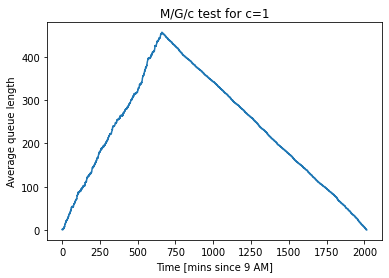

In [43]:
# Test 1: one server/queue
test_simulation(num_of_queues=1)

The total number of people that have joined queue No. 1: 221
The total number of people that have joined queue No. 2: 220
The total number of people that have joined queue No. 3: 199
The total number of people that have joined manager queue: 32
Store finished serving 640 customers 11.0 hours 7.64 mins after 9AM


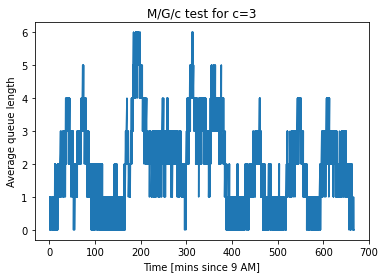

In [44]:
# Test 2: three servers/queues
test_simulation(num_of_queues=3)

### Experiment

Run an experiment for different number of servers/queues for M/G/c system.

In [45]:
def run_experiment(num_queues_list, measurement, num_trials=10, run_until=540):
    '''
    Run an experiment with different number of queues for an M/G/c model.
    '''
    
    # We record only the mean and standard error of the mean for each experiment
    results_mean = []
    results_std_err = []

    arrival_distribution = sts.expon(scale=1/1)
    service_distribution = sts.norm(loc=3, scale=1)
    manager_service_distribution = sts.norm(loc=5, scale=2)

    for num in tqdm(num_queues_list):
        results = []
        for trial in range(num_trials):
            grocery_store, plot_data = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, 
                manager_service_distribution=manager_service_distribution, run_until=run_until, num_of_queues=num)
            if measurement in ["People in queue", "Total people in system"]:
                data = plot_data[measurement]
                results += list(zip(*data))[0]
            else:
                results += plot_data[measurement]
        results_mean.append(np.mean(results))
        results_std_err.append(sts.sem(results))

    # Convert lists to arrays so we can easily add, subtract, and multiply them
    results_mean = np.array(results_mean)
    results_std_err = np.array(results_std_err)
    
    return results_mean, results_std_err

In [46]:
# Run the M/G/1 queue experiment
num_queues_list = [i for i in range(1, 11)]
num_trials = 10
run_until = 660
print(num_queues_list)

np.random.seed(123)
waiting_times_mean, waiting_times_std_err = run_experiment(num_queues_list, measurement="Waiting times", num_trials=num_trials, run_until=run_until)
response_times_mean, response_times_std_err = run_experiment(num_queues_list, measurement="Response times", num_trials=num_trials, run_until=run_until)
queue_length_mean, queue_length_std_err = run_experiment(num_queues_list, measurement="People in queue", num_trials=num_trials, run_until=run_until)
total_people_in_system_mean, total_people_in_system_std_err = run_experiment(num_queues_list, measurement="Total people in system", num_trials=num_trials, run_until=run_until)
print('M/G/c experiment complete')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]

M/G/c experiment complete


In [47]:
# Average waiting times for number of queues ranging from 1 to 10
waiting_times_mean

array([685.93161246, 168.00269184,  14.781275  ,   2.07223   ,
         1.73893258,   1.65127042,   1.6611725 ,   1.63051256,
         1.64791934,   1.63892045])

In [48]:
# Average response times for number of queues ranging from 1 to 10
response_times_mean

array([656.76082141, 170.18793702,  16.46390988,   5.06742346,
         4.65555801,   4.60106093,   4.66674515,   4.59174491,
         4.67831315,   4.62620927])

In [49]:
# Average queue lengths for number of queues ranging from 1 to 10
queue_length_mean

array([2.17952137e+02, 5.79068704e+01, 5.96626187e+00, 6.62021858e-01,
       4.42948445e-01, 3.44780508e-01, 2.98889926e-01, 2.67938671e-01,
       2.35075064e-01, 2.05631615e-01])

In [50]:
# Average number of customers in the system for number of queues ranging from 1 to 10
total_people_in_system_mean

array([227.39816269, 108.60503674,  18.04645744,   5.43368288,
         5.15533141,   5.04475511,   5.11963979,   5.13610756,
         5.02657249,   5.24977951])